# Quantization Aware Training Using Tensorflow

- This creates a model which is already quantized.
- This is opposite to post model quantization where we prune the weights of the model after training.
- Here we train a model that already knows what quantized weights are.
- It does reduced precision training.
- Advantage over post model is accuracy. Model is qunatization aware so it is better than post quantization.
- It does integer arithmetic, so it is pretty fast with CPU.
- Train on GPU infer of CPU.
- Useful for edge Devices.

# GET THE DATA

In [0]:
!nvidia-smi

In [3]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 174kB 2.8MB/s 
     |████████████████████████████████| 296kB 11.7MB/s 


In [4]:
import tensorflow as tf
print(tf.__version__)
import os
import tensorflow_datasets as tfds
import datetime

2.2.0


In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
dataset, info = tfds.load(name="fashion_mnist", with_info=True, as_supervised=True, try_gcs=True, split=["train", "test"])

In [0]:
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)

In [0]:
fm_train, fm_test = dataset[0], dataset[1]
fm_val = fm_test.take(30000)
fm_test = fm_test.skip(30000).take(30000)

In [9]:
# print(len(list(fm_train)))

60000


# Inspect Data

Label 2 
Category Pullover 


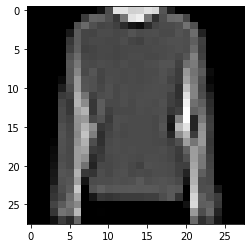

Label 1 
Category Trouser 


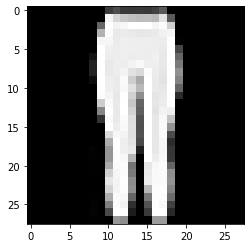

Label 8 
Category Bag 


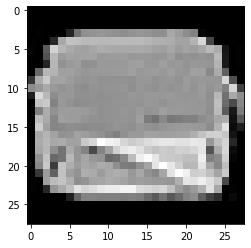

Label 4 
Category Coat 


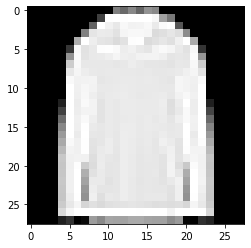

Label 1 
Category Trouser 


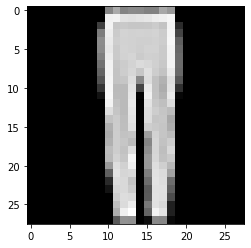

In [10]:
import matplotlib.pyplot as plt
import numpy as np

for fm_sample in fm_train.take(5):
    image, label = fm_sample[0], fm_sample[1]

    plt.figure()
    plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap="gray") 
    print("Label %d " %label.numpy())
    print("Category %s "%info.features["label"].names[label.numpy()])
    plt.show()


# Get THE MODEL

In [0]:
def scale(img, label):
    img = tf.cast(img, tf.float32)
    img /= 255.
    return img, label

In [0]:
def get_dataset(batch_size=32):
    train_dataset_scaled = fm_train.map(scale).shuffle(60000).batch(batch_size)
    test_dataset_scaled = fm_test.map(scale).batch(batch_size)
    val_dataset_scaled = fm_val.map(scale).batch(batch_size)

    return train_dataset_scaled, test_dataset_scaled, val_dataset_scaled

In [0]:
def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, 2, padding="same", activation="relu", input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(128, 2, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, 2, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    return model
    

# Quantize The Model

In [0]:
import tensorflow_model_optimization as tfmot

In [0]:
model = create_model()

In [0]:
quantized_model = tfmot.quantization.keras.quantize_model(model)

In [0]:
quantized_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [0]:
quantized_model.summary()

In [0]:
logdir = os.path.join("/tmp/logs", datetime.datetime.now().strftime("%Y%m%d-%H%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [0]:
train_dataset, test_dataset, val_dataset = get_dataset()

In [21]:
train_dataset.cache()
val_dataset.cache()

<DatasetV1Adapter shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>

In [0]:
history = quantized_model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=[tensorboard_callback])

- Still after training the output is float 32 weights.

- It is just aware of Quantization. We still need to quantize it so that it will be in int.


In [0]:
model.save("/tmp/fashion_model.h5")

# Check the tensorBoard

In [0]:
%load_ext tensorboard

In [0]:
%tensorboard --logdir /tmp/logs

In [26]:
!nvidia-smi

Fri May 15 14:17:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    43W / 250W |    855MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [27]:
print(quantized_model)

In [28]:
quantized_model.evaluate(train_dataset)

1875/1875 [==============================] - 17s 9ms/step - loss: 0.1672 - acc: 0.9384


[0.1671743094921112, 0.9384166598320007]

In [29]:
quantized_model.evaluate(val_dataset)

313/313 [==============================] - 4s 14ms/step - loss: 0.2443 - acc: 0.9124


[0.2442520260810852, 0.9124000072479248]

# Quantize it Fully

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(quantized_model)
converter_optimizations = [tf.lite.Optimize.DEFAULT]

In [0]:
quantized_tflite_model = converter.convert()

In [32]:
quantized_model_size = len(quantized_tflite_model) / 1024
print("Size of quantized model %d KBs"%(quantized_model_size))

Size of quantized model 681 KBs


# Infer on the Qunatized Model

In [0]:
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

In [0]:
input_tensor_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.tensor(interpreter.get_output_details()[0]["index"])

In [0]:
interpreter.get_tensor_details()

In [0]:
prediction_output = []
accurate_count = 0

In [0]:
for test_image in fm_val.map(scale):
    # print("Hi wWT")
    test_image_p = np.expand_dims(test_image[0], axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image_p)

    interpreter.invoke()
    out = np.argmax(output_index()[0])
    prediction_output.append(out)
    # print(out)

    if out == int(test_image[1].numpy()):
        accurate_count += 1


In [0]:
accuracy = accurate_count / len(prediction_output)

In [86]:
print("Accuracy = %0.4f "%(accuracy * 100))

Accuracy = 91.2500 
